## Browser Fingerprint Exercise

<div style="float: right;"><img src="files/images/fingerprint.jpg" width="400px"></div>
<font size=4>Is my network traffic lying to me? Most malware authors don’t seem to spend a lot of effort trying to blend into network traffic. I’m pretty sure the reason for this is “they don’t need to”. By identifying legitimate HTTP requests based on browser request structure we may be able to, more easily, identify malicious traffic. This notebook will focus on some ways to gather legit browser requests, understand them, and use that data to find non-legitiate requests.
<br><br>**Disclaimer:** This exercise in particular is super 'rough', especially towards the end we just kinda threw stuff at the wall to see what would stick. Please take the material in the notebook as purely experimental :).
<br><br>**See:**https://github.com/ClickSecurity/data_hacking/issues/9
<br><br>
** All Code and IPython Notebooks for this talk http://clicksecurity.github.io/data_hacking **
<br><br>
Tools:
<ul>
  <li>Bro Network Security Monitor (http://www.bro.org)
<br>Bro provides a comprehensive platform for network traffic analysis. Well grounded in more than 15 years of research, Bro has successfully bridged the traditional gap between academia and operations since its inception.
  <br><br>
  <li> IPython: A mad scientist notebook! (http://ipython.org)
  <ul><li> What did you do?
  <li> How did you do it?
  <li> Can I repoduce it?
  <li> Easy to share:
  <ul>
  <li>[NB Viewer](http://nbviewer.ipython.org)
  <li>[Reddit IPython](http://www.reddit.com/r/ipython)
  </ul>
  </ul>
  <br>
  <li> Pandas: Python Data Analysis Library (http://pandas.pydata.org)
  <ul>
  <li> A fast and efficient DataFrame object
  <li> Great set of IO Tools
  <li> Fantastic handling of missing data
  <li> Flexible reshaping and pivoting
  <li> Slicing, indexing, and subsetting
  </ul>
</ul>

Contributions:
<ul>
  <li>Wireshark101 (Laura Chappell) http://wiresharkbook.com/101_supplements/wireshark101files.zip
  <li>Contagio Malware Dump - CrimeWare PCAPs (http://contagiodump.blogspot.com/2013/04/collection-of-pcap-files-from-malware.html)
</ul>

Approach:
<ul>
  <li> Exploration and Understanding
  <li> Some Simple Statistics
  <li> Similarity Generation on Sparse Data
  <li> Hierarchical Clustering
  <li> Automatic Regular Expression Generation
</ul>
</font>

In [1]:
import pandas as pd
pd.__version__

u'0.20.3'

In [2]:
import numpy as np
np.__version__

'1.13.1'

In [3]:
# Just some plotting defaults
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 12.0, 8.0

<div style="float: left; margin: 0px 30px 0px 0px"><img src="files/images/disk.jpg" width="250px"></div>
# Read in the Data
<font size=4>We have a nice Bro log reader that will take in any Bro log output and give you a generator of dictionaries (efficient python datastructure. That could be use directly or just passed to a panda dataframe constructor </font>

In [7]:
# Create a BRO log file reader and pull from the logfile
import bro_log_reader
bro_log = bro_log_reader.BroLogReader()
headers = bro_log.read_log('data/http_headers.log')

In [6]:
headers.next()

{'header_events_json': '[{"ACCEPT":"*\\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]',
 'origin': 'client',
 'ts': datetime.datetime(2012, 3, 31, 7, 32, 57, 382264),
 'useragent': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)'}

In [8]:
# Nice, so lets look at some of the outputs by tossing them into a pandas dataframe
dataframe = pd.DataFrame(headers)

In [9]:
# What do we have
print 'Number of Rows: %d   Columns:%d' % (dataframe.shape[0], dataframe.shape[1])
dataframe.head()

Number of Rows: 4576   Columns:4


header_events_json  origin  \
0  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
1  [{"CACHE-CONTROL":"no-cache"},{"DATE":"Fri, 30...  server   
2  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
3  [{"CACHE-CONTROL":"no-cache"},{"DATE":"Fri, 30...  server   
4  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   

                          ts  \
0 2012-03-31 07:32:57.382264   
1 2012-03-31 07:32:57.382264   
2 2012-03-31 07:32:57.382264   
3 2012-03-31 07:32:57.382264   
4 2012-03-31 07:32:57.382264   

                                           useragent  
0  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...  
1                                                 NA  
2  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...  
3                                                 NA  
4  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...

<div style="float: left; margin: 0px 30px 0px 0px"><img src="files/images/processing_data.jpg" width="250px"></div>
# Process the Data
We're going to use some nice functionality in the Pandas dataframe to process our data:

    - We have both client and server events, just keep the client events for this exercise
    - Transform the complicated user-agent string into something more managable (short-agent)
    - Generate a 'feature vector' from the header keys

In [10]:
# Okay so were only interested in client header requests for this exercise
dataframe = dataframe[dataframe['origin']=='client']

In [11]:
dataframe

header_events_json  origin  \
0     [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
2     [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
4     [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
6     [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"}...  client   
8     [{"ACCEPT":"text\/html, application\/xhtml+xml...  client   
10    [{"ACCEPT":"text\/css"},{"REFERER":"http:\/\/2...  client   
11    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
13    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
14    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
16    [{"ACCEPT":"text\/css"},{"REFERER":"http:\/\/2...  client   
19    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
21    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
22    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
23    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
26    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
29    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
31    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
33    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
36    [{"ACCEPT":"application\/javascript, *\/*;q=0....  client   
38    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
39    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
40    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
41    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
42    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
43    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
50    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
51    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
54    [{"ACCEPT":"*\/*"},{"ACCEPT-ENCODING":"gzip, d...  client   
56    [{"ACCEPT":"image\/png, image\/svg+xml, image\...  client   
58    [{"ACCEPT":"text\/html, application\/xhtml+xml...  client   
...                                                 ...     ...   
4512  [{"HOST":"tag.contextweb.com"},{"USER-AGENT":"...  client   
4515  [{"HOST":"tag.contextweb.com"},{"USER-AGENT":"...  client   
4519  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4520  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4523  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4525  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4527  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4529  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4530  [{"HOST":"anonsvn.wireshark.org"},{"USER-AGENT...  client   
4533  [{"HOST":"www.wireshark.org"},{"USER-AGENT":"M...  client   
4535  [{"HOST":"ipv4.wireshark.org"},{"USER-AGENT":"...  client   
4537  [{"HOST":"ipv6.wireshark.org"},{"USER-AGENT":"...  client   
4539  [{"HOST":"wiresharkdownloads.riverbed.com"},{"...  client   
4541  [{"CACHE-CONTROL":"no-cache"},{"CONNECTION":"K...  client   
4543  [{"HOST":"www.memeo.info"},{"CONNECTION":"Keep...  client   
4545  [{"HOST":"api.memeo.info"},{"CONNECTION":"Clos...  client   
4547  [{"ACCEPT-LANGUAGE":"en-us"},{"ACCEPT":"*\/*"}...  client   
4549  [{"ACCEPT-LANGUAGE":"en-us"},{"ACCEPT":"*\/*"}...  client   
4551  [{"ACCEPT-LANGUAGE":"en-us"},{"ACCEPT":"*\/*"}...  client   
4554  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4555  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4557  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4560  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4561  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4564  [{"USER-AGENT":"Mozilla\/4.0 (compatible)"},{"...  client   
4566  [{"HOST":"www.artbrokerage.com"},{"USER-AGENT"...  client   
4567  [{"HOST":"www.ulisseide.org"},{"USER-AGENT":"M...  client   
4570  [{"HOST":"3xsd5p828s.cz.cc"},{"USER-AGENT":"Mo...  client   
4572  [{"HOST":"3

In [12]:
# Okay we also want to process the header events (that are in a JSON blob) 
# into a header feature vector (just pulling 'keys' not values).
import json
def make_header_features(json_header_info_series):
    header_features = []
    for header_info in json_header_info_series:
        try:
            header_list = json.loads(unicode(header_info, 'utf8'))
            features = [item.keys()[0] for item in header_list]
        # There are some lines w/no features
        except Exception as e:
            features = ''
        header_features.append(features)
    return header_features

# Create a nicely formatted feature vector and a string representation
dataframe['feature_vector'] = make_header_features(dataframe['header_events_json'])
dataframe['features'] = dataframe['feature_vector'].map(lambda x: ':'.join(x))

In [21]:
import pandas as pd
pd.set_option('max_colwidth', 2000)
pd.set_option("display.width",2000)
dataframe.head()

header_events_json  origin                         ts                                                                                                                                                                                               useragent                                                                                     feature_vector                                                                                  features
0  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE
2  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE
4  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE
6  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE
8                                                                                                                                              [{"ACCEPT":"text\/html, application\/xhtml+xml, *\/*"},{"ACCEP

<div style="float: left; margin: 0px 30px 0px 0px"><img src="files/images/shortagent.jpg" width="250px"></div>
## Short Agents?
So what are we doing with the user-agent strings, how are we doing it and why are we doing it?

The user-agent strings are verbose with lots of information and variety based on agent versions/platforms/layout engines/dll linked/builds etc... the logic around short agent strings it to capture the essence of what the agent IS. So for instance this user-agent string becomes this short-agent:

    - User-agent: Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; .NET CLR 1.0.3705; .NET CLR 1.1.4322; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; InfoPath.3; SRC 2.7.1 E1; MS-RTC LM 8; BRI/2; BOIE8;ENUSMSNIP)
    
    - short-agent: mozilla/4.0:msie:7.0:windows:nt:5.1:trident/4.0:n1.0:n1.1:n2.0:n3.0:n3.5 

In [22]:
# Making shorter agent names based on information from
# http://msdn.microsoft.com/library/ms537503.aspx
import re
def replace_stuff(m):
    return 'n'+m.group(1) if '.net clr' in m.group() else ''
def short_agent_names(useragent_series, resolution=12):
    short_agent_list = []
    excludes = re.compile(r',|;|\(|\)|compatible|\.net clr ([0-9].[0-9])[^;]*;|khtml,|like')
    for useragent in useragent_series:
        processed_user_agent = re.sub(excludes, replace_stuff, useragent.lower()).strip()
        short_agent = ':'.join(processed_user_agent.split()[:resolution])
        short_agent_list.append(short_agent)
    return short_agent_list

In [23]:
# Generate shorter agent names
dataframe['short_agent'] = short_agent_names(dataframe['useragent'])
# Remove any 'na' agents
dataframe = dataframe.replace('na',np.nan)
dataframe = dataframe.dropna()

In [25]:
dataframe.head()

header_events_json  origin                         ts                                                                                                                                                                                               useragent                                                                                     feature_vector                                                                                  features                                                                 short_agent
0  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE  mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0
2  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE  mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0
4  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION, COOKIE]  ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE  mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0
6  [{"ACCEPT":"*\/*"},{"ACCEPT-LANGUAGE":"en-US"},{"X-FLASH-VERSION":"11,1,102,55"},{"ACCEPT-ENCODING":"gzip, deflate"},{"USER-AGENT":"Mozilla\/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident\/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)"},{"HOST":"trk.vindicosuite.com"},{"CONNECTION":"Keep-Alive"},{"COOKIE":"-"}]  client 2012-03-31 07:32:57.382264  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; HPNTDF; InfoPath.2; .NET4.0C; .NET4.0E)  [ACCEPT, ACCEPT-LANGUAGE, X-FLASH-VERSION, ACCEPT-ENCODING, USER-AGENT, HOST, CONNECTION,

<div style="float: left; margin: 0px 30px 0px 0px"><img src="files/images/eyeball_2.jpg" width="250px"></div>
# Lets look at the Data
We're going to use some nice functionality in the Pandas dataframe to look at our processed data:

    - We can use groupby on the dataframe to see the different header request keys for various agents
    - Transform the complicated user-agent string into something more managable (short-agent)
    - Generate a 'feature vector' from the header keys

In [62]:
# Okay lets exercise some of the pandas dataframe functionality
dataframe['count'] = 1
agent_group_df = dataframe.groupby(['short_agent','features']).sum()
agent_group_df.head(20)

count
short_agent                                                                  features                                                                                                                                           
memeo:autobackup:/4.60.0.7923:/platform=1                                    ACCEPT-LANGUAGE:ACCEPT:USER-AGENT:HOST:CONNECTION                                                                                                 2
microsoft-cryptoapi/6.1                                                      CACHE-CONTROL:CONNECTION:ACCEPT:IF-MODIFIED-SINCE:IF-NONE-MATCH:USER-AGENT:HOST                                                                   2
                                                                             CACHE-CONTROL:CONNECTION:ACCEPT:IF-MODIFIED-SINCE:USER-AGENT:HOST                                                                                 3
                                                                             CONNECTION:ACCEPT:IF-MODIFIED-SINCE:IF-NONE-MATCH:USER-AGENT:HOST                                                                                 2
                                                                             CONNECTION:ACCEPT:USER-AGENT:HOST                                                                                                                 3
mozilla/4.0                                                                  USER-AGENT:HOST                                                                                                                                   3
                                                                             USER-AGENT:HOST:IF-MODIFIED-SINCE:IF-NONE-MATCH:CONNECTION                                                                                        3
mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322                    ACCEPT:ACCEPT-LANGUAGE:XXXXXXXXXXXXXXX:USER-AGENT:HOST:CONNECTION                                                                                 1
mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0   ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION                                                         1
                                                                             ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE                                                          4
mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5 ACCEPT:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION                                                                                                 2
                                                                             ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION                                                        15
                                                                             ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE                                                 12
                                                                             ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:CONTENT-TYPE:CONTENT-LENGTH:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:CACHE-CONTROL:COOKIE        1
                                                                             ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:CONTENT-TYPE:X-VERIFY:CONTENT-LENGTH:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:CACHE-CONTROL      1
                                                                             ACCEPT:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION                                                                                 2
                                                                             ACCEPT:ACCEPT-LANGUAGE:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION           

In [63]:
# Now lets get the number of different header sequence permutations per agent
agent_counts = agent_group_df.count(level=0)

# Looks like MSIE agents have a higher number of permutations than all the other stuff
# So we 'groupby' a conditional statement (do you have msie in your agent string)
agent_types = agent_counts.groupby(by=lambda x: 'msie' if 'msie' in x else 'other')
agent_types.head(20)

count
      short_agent                                                                                             
other memeo:autobackup:/4.60.0.7923:/platform=1                                                              1
      microsoft-cryptoapi/6.1                                                                                4
      mozilla/4.0                                                                                            2
msie  mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322                                              1
      mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0                             2
      mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5                          12
      mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5                          17
      mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0                                                  4
      mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06                                             3
other mozilla/5.0:windows:nt:6.1:wow64:rv:12.0:gecko/20100101:firefox/12.0                                   2
      mozilla/5.0:windows:nt:6.1:wow64:rv:14.0:gecko/20100101:firefox/14.0.1                                 5
      mozilla/5.0:windows:nt:6.1:wow64:rv:16.0:gecko/20100101:firefox/16.0                                  25
      mozilla/5.0:windows:u:windows:nt:6.1:en-us:rv:1.9.2.18:gecko/20110614:firefox/3.6.18                   4
      nis/19.9.0.9:mid/{grpgbpdjzi9qbdsno/32ukaorrc}:sid/fhkuuaaaaaa                                         1
      nis/19.9.0.9:mid/{grpgbpdjzi9qbdsno/32ukaorrc}:sid/fhkuuaaaaaa:lue/1.8.2.10:windows6.1sp1.0x64enu      1
      shasta                                                                                                 1
      shockwave:flash                                                                                        6

[17 rows x 1 columns]

{'boxes': [<matplotlib.lines.Line2D at 0x10b266e50>,
 'caps': [<matplotlib.lines.Line2D at 0x10b2661d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10b269a10>,
 'medians': [<matplotlib.lines.Line2D at 0x10b2693d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10b260850>,
  <matplotlib.lines.Line2D at 0x10b26dc90>]}

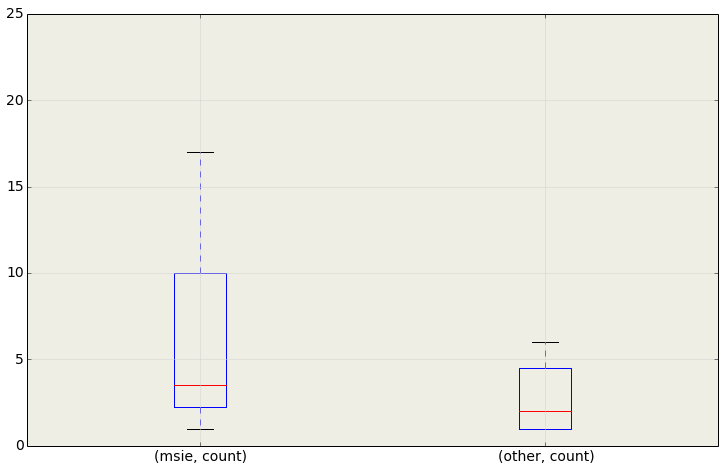

In [64]:
# Get some quick descriptive stats and plot it!
fig, ax = plt.subplots(subplot_kw={'axisbg':'#EEEEE5'})
ax.grid(color='lightgrey', linestyle='solid')
agent_types.boxplot(False)

In [65]:
# Now lets flip the group by around
features = dataframe[['short_agent','features','count']].groupby(['features','short_agent']).sum()
print features.shape
features.head(20)

(91, 1)


count
features                                                                                                                                     short_agent                                                                        
ACCEPT-LANGUAGE:ACCEPT:USER-AGENT:HOST:CONNECTION                                                                                            memeo:autobackup:/4.60.0.7923:/platform=1                                         2
ACCEPT:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION                                                                                            mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5      2
                                                                                                                                             mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5      5
                                                                                                                                             mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0                             1
                                                                                                                                             mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06                        3
ACCEPT:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE                                                                                     mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5      9
ACCEPT:ACCEPT-ENCODING:USER-AGENT:IF-MODIFIED-SINCE:HOST:CONNECTION:COOKIE                                                                   mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5      8
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION                                                    mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0        1
                                                                                                                                             mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5     15
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE                                             mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5     12
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:ACCEPT-ENCODING:USER-AGENT:IF-MODIFIED-SINCE:HOST:CONNECTION                                  mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5      1
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:CONTENT-TYPE:CONTENT-LENGTH:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:CACHE-CONTROL:COOKIE   mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5      1
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-FLASH-VERSION:CONTENT-TYPE:X-VERIFY:CONTENT-LENGTH:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:CACHE-CONTROL mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5      1
ACCEPT:ACCEPT-LANGUAGE:REFERER:X-SVN-REV:ACCEPT-ENCODING:USER-AGENT:HOST:CONNECTION:COOKIE                                                   mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5      1
ACCEPT:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION                                                                            mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5      2
                                                                                                                                             mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06                        2
ACCEPT:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION:COOKIE                                                                     mozilla/4.0:msie:8.0:windows

<div style="float: right; margin: 50px 0px 50px -50px"><img src="files/images/confused.jpg" width="450px" style="margin: 0px"></div>
### Okay...so after looking at the data we have a better 'feel' it... but now what?
### Perhaps we should try a different approach.
1. **Compute similarities between all rows within the system log using LSH:  **
   Unlike conventional hash functions the goal of LSH (Locality Sensitive Hashing) is to maximize probability of "collision" of similar items rather than avoid collisions.
    * [MinHash](http://en.wikipedia.org/wiki/MinHash)
    * [Locality Sensitive Hashing](http://en.wikipedia.org/wiki/Locality_sensitive_hashing)
    * [Mining of Massive Datasets](http://infolab.stanford.edu/~ullman/mmds/ch3.pdf)
2. **Use those similarities as the basis of a Hierarchical Clustering Algorithm:  **
    Single-linkage clustering is one of several methods for agglomerative 
    hierarchical clustering.
    - [Single Linkage Clustering](http://en.wikipedia.org/wiki/Single-linkage_clustering)
    - [Hierarchical Clustering](http://en.wikipedia.org/wiki/Hierarchical_clustering)
    
    Other popular online clustering algorithms
    - [DBSCAN](http://en.wikipedia.org/wiki/DBSCAN)
    - [OPTICS Algorithms](http://en.wikipedia.org/wiki/OPTICS_algorithm)
    

#### The LSH Sims python class has two distance metrics

1) Jaccard Index: a set based distance metric (overlaps in sets of elements)
  
   - [Jaccard Index](http://en.wikipedia.org/wiki/Jaccard_index)

2) Levenshtein Distance: based on the edit distance of the elements (so order matters).
  
   - [Levenshtein Distance](http://en.wikipedia.org/wiki/Levenshtein_distance)
   - [Damerau-Levenshtein Distance](http://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance) (not using but good to be aware of)
   - Using a code snippet from [Michael Homer](http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance)
   - Also using the [difflib](http://docs.python.org/2/library/difflib.html#sequencematcher-examples) module for editops

<div style="float: right; margin: 50px 0px 00px 20px"><img src="files/images/levenshtein.png" width="450px" style="margin: 0px"></div>
## What the F&*# is a Levenshtein!?
"The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (i.e. insertions, deletions or substitutions) required to change one word into the other."  [Levenshtein Distance (WikiPedia)](http://en.wikipedia.org/wiki/Levenshtein_distance)

In this case we are using Levenshtein not on individual letters in strings but tokens in sequences.

Examples: 

    a = ['ACCEPT', 'USER-AGENT', 'HOST', 'COOKIE']
    b = ['ACCEPT', 'USER-AGENT', 'HOST']
    c = ['ACCEPT', 'USER-AGENT', 'DORSEYS-MOM']
    d = ['COOKIE', 'ACCEPT', 'USER-AGENT', 'HOST']

    levenshtein(a,b) = 1.0
    levenshtein(b,c) = 1.0
    levenshtein(a,d) = 2.0

In [66]:
# Lets look at the a few examples of Levenshtein distance
import data_hacking.lsh_sims as lsh_sims
lsh = lsh_sims.LSHSimilarities([])
a = ['ACCEPT', 'USER-AGENT', 'HOST', 'COOKIE']
b = ['ACCEPT', 'USER-AGENT', 'HOST']
c = ['ACCEPT', 'USER-AGENT', 'DORSEYS-MOM']
d = ['COOKIE', 'ACCEPT', 'USER-AGENT', 'HOST']

print 'Levenshtein: %s -- %s   ( %f )' % (a, b, lsh.levenshtein(a, b))
print 'Levenshtein: %s -- %s   ( %f )' % (b, c, lsh.levenshtein(b, c))
print 'Levenshtein: %s -- %s   ( %f )' % (a, d, lsh.levenshtein(a, d))

Levenshtein: ['ACCEPT', 'USER-AGENT', 'HOST', 'COOKIE'] -- ['ACCEPT', 'USER-AGENT', 'HOST']   ( 1.000000 )
Levenshtein: ['ACCEPT', 'USER-AGENT', 'HOST'] -- ['ACCEPT', 'USER-AGENT', 'DORSEYS-MOM']   ( 1.000000 )
Levenshtein: ['ACCEPT', 'USER-AGENT', 'HOST', 'COOKIE'] -- ['COOKIE', 'ACCEPT', 'USER-AGENT', 'HOST']   ( 2.000000 )


In [67]:
# Lets compute levenshtein distance between the header sequences for each agent
params = {'num_hashes':20, 'lsh_bands':20, 'lsh_rows':1, 'drop_duplicates':True}

agent_distances = {}
agent_groups = dataframe.groupby(['short_agent'])
for name, group in agent_groups:
    lsh = lsh_sims.LSHSimilarities(group['feature_vector'], mh_params=params)
    distances = lsh.batch_compute_similarities(distance_metric='levenshtein_tapered', threshold=10)
    distances.sort() 
    agent_distances[name] = distances

In [68]:
# For one agent show the top 5 closest (levenshtein) header sequences
agent = 'mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0'
distances = agent_distances[agent]

print '\nAgent: %s' % agent
print 'Distances:'
features = agent_groups.get_group(agent)['feature_vector']
for distance in distances[:5]:
    print '\n%s\n%s' % (features.iloc[distance[1]], features.iloc[distance[2]])


Agent: mozilla/4.0:msie:7.0:windows:nt:6.1:wow64:trident/5.0:slcc2:n2.0:n3.5:n3.0
Distances:

[u'ACCEPT', u'ACCEPT-LANGUAGE', u'X-FLASH-VERSION', u'ACCEPT-ENCODING', u'USER-AGENT', u'HOST', u'CONNECTION', u'COOKIE']
[u'ACCEPT', u'ACCEPT-LANGUAGE', u'REFERER', u'X-FLASH-VERSION', u'ACCEPT-ENCODING', u'USER-AGENT', u'HOST', u'CONNECTION']


<div style="float: right; margin: 20px 20px 20px 20px"><img src="files/images/agg.jpg" width="400px" style="margin: 10px"></div>
# Hierarchical Clustering 
Now we can use those similarities as the basis of a Hierarchical Clustering Algorithm. Single-linkage clustering is one of several methods for agglomerative hierarchical clustering. The image on the right is an example of how this works. 

We're using a bottom up method (image is flipped :), you simply sort the similarities and start building your tree from the bottom. If B and C are the most similar you link them, then D/E and so on until you complete the tree. The devil is **definitely** in the details on the implementation of this, so luckily we have a python class that does it for us.

In [69]:
# MLPD3 is a cool python module for using D3 as a back end to matplotlib
# go to https://github.com/jakevdp/mpld3 and behold the awesome.

# Note we're commenting this out that the nbviewer work correctly, 
# but feel free to uncomment if you download the notebook and play
# with it yourself.
'''
try:
    import mpld3
    mpld3.enable_notebook(d3_url="/files/d3/d3.v3.js")
except ImportError:
    print 'Info: Could not load mpld3 module. No worries stuff will still work fine...'
'''

'\ntry:\n    import mpld3\n    mpld3.enable_notebook(d3_url="/files/d3/d3.v3.js")\nexcept ImportError:\n    print \'Info: Could not load mpld3 module. No worries stuff will still work fine...\'\n'

In [70]:
# Compute a hierarchical clustering from the header similarities for each agent
import data_hacking.hcluster as hcluster
agent_h_graphs = {}
groups = dict(list(agent_groups))
for name, group in groups.iteritems():
    lsh = lsh_sims.LSHSimilarities(group['feature_vector'], mh_params=params)
    distances = lsh.batch_compute_similarities(distance_metric='l_tapered_sim', threshold=0)
    h_clustering = hcluster.HCluster(group['feature_vector'])
    h_clustering.set_sim_method(lsh.l_sim)
    h_graph, root = h_clustering.sims_to_hcluster(distances, agg_sim=.2)
    agent_h_graphs[name] = {'graph':h_graph, 'root':root}

<<<< WTF Error: Looks like an empty graph >>>>>
Graph 0 nodes 0 edges
<<<< WTF Error: Looks like an empty graph >>>>>
Graph 0 nodes 0 edges
<<<< WTF Error: Looks like an empty graph >>>>>
Graph 0 nodes 0 edges
<<<< WTF Error: Looks like an empty graph >>>>>
Graph 0 nodes 0 edges
<<<< WTF Error: Looks like an empty graph >>>>>
Graph 0 nodes 0 edges


In [71]:
# Plot a couple of agents
import networkx as nx

def plot_h_tree(graph, layout='neato'):
    pos = nx.graphviz_layout(graph, prog=layout)
    labels = {node[0]:node[1]['label'] for node in graph.nodes(data=True)}
    nx.draw_networkx(graph, pos, node_size=800, alpha=.7, node_color=[.6,.4,.6], labels=labels)
    edge_labels=dict([((u,v,),str(d['weight'])[:4]) for u,v,d in graph.edges(data=True)])
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels)

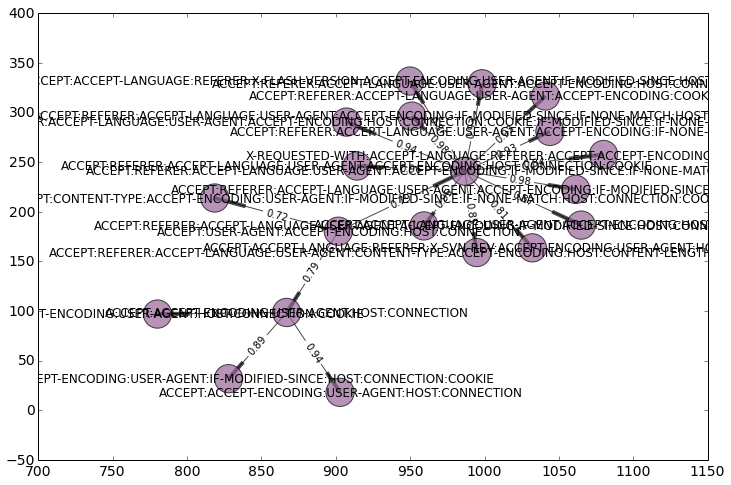

In [72]:
# MSIE 8
msie_8 = 'mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5'
plot_h_tree(agent_h_graphs[msie_8]['graph'])

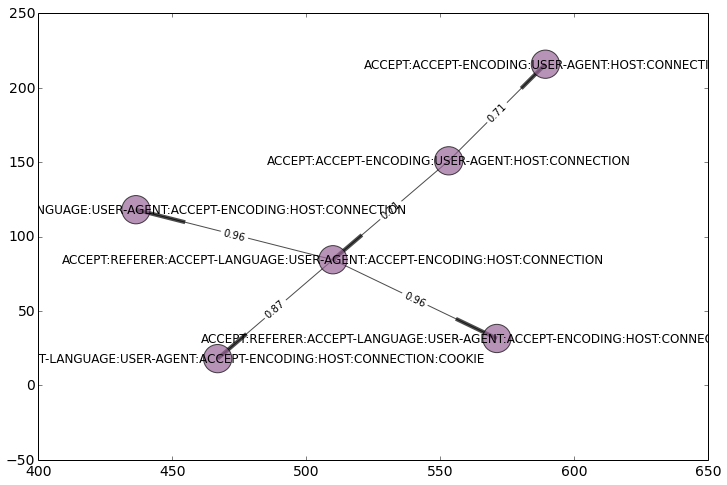

In [73]:
msie_9 = 'mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0'
plot_h_tree(agent_h_graphs[msie_9]['graph'])

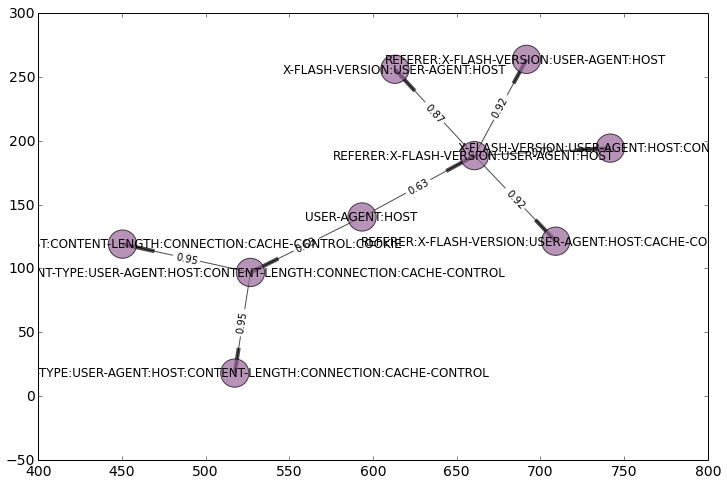

In [74]:
flash = 'shockwave:flash'
plot_h_tree(agent_h_graphs[flash]['graph'])

In [75]:
import collections
def subtree_labels(g, root):
    labels = nx.get_node_attributes(g,'label')
    sub_labels = collections.defaultdict(list)
    leaves = [k for k,v in g.out_degree().iteritems() if v == 0]
    for leaf in leaves:
        sub_labels[g.predecessors(leaf)[0]].append(labels[leaf])
    return sub_labels

import pprint
g = agent_h_graphs[good_test_agent]['graph']
root = agent_h_graphs[good_test_agent]['root']

In [76]:
# Hmph, well just for fun we made a RE Morpher class; you simply keep adding
# strings to it and it figures out the RE that matches all the strings.
# It's very hack-tastic so a better way to auto-generate regular expressions 
# will be a fun task for some contributor :)
import re
import re_morpher

# Lets experiment a bit
a = [u'HOST', u'CONNECTION', u'ACCEPT', u'USER-AGENT', u'ACCEPT-ENCODING']
b = [u'HOST', u'CONNECTION', u'AUTHORIZATION', u'ACCEPT', u'USER-AGENT', u'ACCEPT-ENCODING']
b = [u'HOST', u'CONNECTION', u'AUTHORIZATION', u'ACCEPT', u'USER-AGENT', u'DORSEYS-MOM']

my_re_morpher = re_morpher.REMorpher()
my_re_morpher.add_sequence(a)
print my_re_morpher.get_re_pattern()
my_re_morpher.add_sequence(b)
print my_re_morpher.get_re_pattern()

^HOSTCONNECTIONACCEPTUSER-AGENTACCEPT-ENCODING$
^HOSTCONNECTION(AUTHORIZATION)?ACCEPTUSER-AGENT(DORSEYS-MOM)?(ACCEPT-ENCODING)?$


In [87]:
# Alright now try it out on our agents header sequences
import collections
agent_res = collections.defaultdict(list)
for agent, graph_info in agent_h_graphs.iteritems():
#for agent, graph_info in zip(good_test_agent,agent_h_graphs[good_test_agent]):
    graph = graph_info['graph']
    root = graph_info['root']
    if graph:
        # Get the re patterns for this agent
        for sub_key, feature_list in subtree_labels(graph,root).iteritems():
            for f in feature_list:
                my_re_morpher.add_sequence(f.split(':'))

            # Append to my re list
            agent_res[agent].append(my_re_morpher.get_re_pattern())
            my_re_morpher.reset_re()
    
# Print out the agent sets just to get an idea
for agent, graph_info in agent_h_graphs.iteritems():
    print '\n%s' % agent
    for my_re in agent_res[agent]:
        print '\t%s' % my_re


mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.4:slcc2:n2.0:n3.5
	^(ACCEPT)?(ACCEPT-LANGUAGE)?(REFERER)?(X-SVN-REV)?(ACCEPT)?(ACCEPT-ENCODING)?(ACCEPT-LANGUAGE)?(USER-AGENT)?(X-FLASH-VERSION)?(ACCEPT-ENCODING)?(ACCEPT-LANGUAGE)?(USER-AGENT)?(CONTENT-TYPE)?(ACCEPT-ENCODING)?(IF-MODIFIED-SINCE)?(IF-NONE-MATCH)?(HOST)?(CONTENT-LENGTH)?(CONNECTION)?(COOKIE)?(IF-NONE-MATCH)?$
	^ACCEPTACCEPT-ENCODINGUSER-AGENT(IF-MODIFIED-SINCE)?HOSTCONNECTION(COOKIE)?$
	^X-REQUESTED-WITHACCEPT-LANGUAGEREFERERACCEPTCONTENT-TYPEACCEPT-ENCODINGUSER-AGENTIF-MODIFIED-SINCEIF-NONE-MATCHHOSTCONNECTIONCOOKIE$

mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06
	^ACCEPT(ACCEPT-ENCODING)?(ACCEPT-LANGUAGE)?USER-AGENT(ACCEPT-ENCODING)?HOSTCONNECTION$

mozilla/4.0:msie:8.0:windows:nt:6.1:wow64:trident/4.0:gtb7.2:slcc2:n2.0:n3.5
	^ACCEPT(REFERER)?ACCEPT-LANGUAGEUSER-AGENTACCEPT-ENCODING(COOKIE)?(CONNECTION)?HOST(CONNECTION)?(COOKIE)?$
	^(X-REQUESTED-WITH)?(ACCEPT)?(ACCEPT-LANGUAGE)?(REFERER)?(ACCEPT)

<div style="float: right; margin: 0px 30px 0px 0px"><img src="files/images/validation.jpg" width="300px"></div>
# Validation and Evaluation

     - Make sure the regular expressions match all the agents/features in the training set.
     - Test the expressions against data/PCAPs that have known bad/sneaky agents.
     
Well by definition the regular expressions are suppose to match the training set, so the first evaluation is more of a sanity check. For the second test we find 'matching' agents in the PCAP file and test their header sequences. 
#### NOTE: This work is fairly embryonic right now and this section in particular needs more formality around it. Also, as always, we need a super huge set of training data to get broader coverage of more agents and all of the permuations.

In [78]:
# An evaluation method for our auto-magically-generated RE expressions
import re
def evaluate_agents(agent_list, feature_list):
    print 'Evaluating %d requests' % len(agent_list)
    for agent, features in zip(agent_list, feature_list):
        my_res = [re.compile(my_re) for my_re in agent_res[agent]]
        match = any([my_re.match(features.replace(':','')) for my_re in my_res])
        if not match:
            print '\nAlert: No Match on Agent(%s) Sequence(%s)' % (agent,features)

In [85]:
# Evaluation against the training set (there should be no alerts)
t_agents = [(len(agent_res[agent])>0) for agent in dataframe['short_agent']] # Degenerate case where no H-Tree was built
training_agents = dataframe[t_agents]
evaluate_agents(training_agents['short_agent'], training_agents['features'])

Evaluating 2268 requests

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION)

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION)

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION)

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION)

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE:USER-AGENT:ACCEPT-ENCODING:HOST:CONNECTION)

Alert: No Match on Agent(mozilla/5.0:msie:9.0:windows:nt:6.1:wow64:trident/5.0:np06) Sequence(ACCEPT:REFERER:ACCEPT-LANGUAGE

In [80]:
# Read in from contagio dumps' pcap samples for evaluation testing
bro_log = bro_log_reader.BroLogReader()
contagio_headers = bro_log.read_log('data/contagio.headers.txt')
contagio_df = pd.DataFrame(contagio_headers)
contagio_df.head()

header_events_json  origin  \
0  [{"ACCEPT":"application\/octet-stream"},{"CONT...  client   
1  [{"DATE":"Sun, 11 Aug 2013 05:25:27 GMT"},{"SE...  server   
2  [{"ACCEPT":"application\/octet-stream"},{"CONT...  client   
3  [{"DATE":"Sun, 11 Aug 2013 05:27:19 GMT"},{"SE...  server   
4  [{"ACCEPT":"application\/octet-stream"},{"CONT...  client   

                          ts   useragent  
0 2013-08-10 23:26:48.150406  Alina v5.3  
1 2013-08-10 23:26:48.150406          NA  
2 2013-08-10 23:28:40.198085  Alina v5.3  
3 2013-08-10 23:28:40.198085          NA  
4 2013-08-10 23:32:41.074339  Alina v5.3  

[5 rows x 4 columns]

In [81]:
# A bit of processing on the raw data to prepate it for evaluation
contagio_df = contagio_df[contagio_df['origin']=='client']
contagio_df['short_agent'] = short_agent_names(contagio_df['useragent'])
contagio_df['feature_vector'] = make_header_features(contagio_df['header_events_json'])
contagio_df['features'] = contagio_df['feature_vector'].map(lambda x: ':'.join(x))

In [82]:
# Lets look at the overlap of agents from our training set and the contagio set
trained_agents = set(dataframe['short_agent'].unique())
evil_agents = set(contagio_df['short_agent'].unique())
evil_agents = evil_agents.intersection(trained_agents)
contagio_subset = contagio_df[contagio_df['short_agent'].isin(evil_agents)]
evil_agents

# Well only a couple of agents overlap our training data, but that's okay 
# still a reasonable set of header requests to test against.

{'microsoft-cryptoapi/6.1',
 'mozilla/4.0',
 'mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322'}

In [83]:
# Lets see how the Contagio CrimeWare PCAP requests measure up against our dataset of computed regex's
evaluate_agents(contagio_subset['short_agent'],contagio_subset['features'])

Evaluating 33 requests

Alert: No Match on Agent(mozilla/4.0) Sequence(CACHE-CONTROL:CONNECTION:PRAGMA:CONTENT-TYPE:USER-AGENT:CONTENT-LENGTH:HOST)

Alert: No Match on Agent(mozilla/4.0) Sequence(CACHE-CONTROL:CONNECTION:PRAGMA:CONTENT-TYPE:USER-AGENT:CONTENT-LENGTH:HOST)

Alert: No Match on Agent(mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322) Sequence(HOST:KEEP-ALIVE:CONNECTION:USER-AGENT)

Alert: No Match on Agent(mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322) Sequence(HOST:KEEP-ALIVE:CONNECTION:USER-AGENT)

Alert: No Match on Agent(mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322) Sequence(HOST:KEEP-ALIVE:CONNECTION:USER-AGENT)

Alert: No Match on Agent(mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322) Sequence(HOST:KEEP-ALIVE:CONNECTION:USER-AGENT)

Alert: No Match on Agent(mozilla/4.0:msie:6.0:windows:nt:5.1:sv1:.net:clr:1.1.4322) Sequence(HOST:KEEP-ALIVE:CONNECTION:USER-AGENT)

Alert: No Match on Agent(mozilla/4.0) Sequence(HOST:USER-AGEN

<div style="float: left;"><figure style="margin: 30px 40px 40px 0px"><img src="files/images/conclusion.jpg" width="350px"></figure></div>
# Conclusions
We read in some Bro log data, did a bit of processing and then applied some neat analytics.
The analytics in this notebook covered these topics and the reader is encourage to visit the respective pages:

   - [Levenshtein_Similarity](http://en.wikipedia.org/wiki/Levenshtein_distance)
   - [Min Hash](http://en.wikipedia.org/wiki/MinHash)
   - [Locality Sensitive Hashing](http://en.wikipedia.org/wiki/Locality_sensitive_hashing)
   - [Hierarchical Clustering](http://en.wikipedia.org/wiki/Hierarchical_clustering)
   - [Automatic Regular Expression Generation](http://regex.inginf.units.it/)
   - [Passive Browser Fingerprinting](http://www.visiblerisk.com/blog/2012/7/2/passive-browser-fingerprinting.html)

In general the material in this notebook represents fairly embryonic work. 
#### Please take the results as a 'work in progress' at this point...

#### Time for the fancy monkeys on a spinning rock in the middle of nowhere to go have some beer!

### Papers on the Automatic Generation of Regular Expressions
Bartoli, Davanzo, De Lorenzo, Mauri, Medvet, Sorio, [Automatic Generation of Regular Expressions from Examples with Genetic Programming](http://machinelearning.inginf.units.it/publications/international-conference-publications/automaticgenerationofregularexpressionsfromexampleswithgeneticprogramming), ACM Genetic and Evolutionary Computation Conference (GECCO), 2012, Philadelphia (US)

De Lorenzo, Medvet, Bartoli, [Automatic String Replace by Examples](http://machinelearning.inginf.units.it/publications/international-conference-publications/automaticstringreplacebyexamples), ACM Genetic and Evolutionary Computation Conference (GECCO), 2013, Amsterdam (Netherlands)—the string replace functionality described in this paper is based on an extension of the work showcased on this web app; it is currently not exposed on the web.

### There's also a neat IPython notebook on generating regular expressions
#### xkcd 1313: Something is Wrong on the Internet!
<a href="http://xkcd.com/1313">![](http://imgs.xkcd.com/comics/regex_golf.png)</a>

The IPython notebook uses a strategy to find a regex that given two python sequences matches the first but ensures that it does not match the second using a [set cover technique](http://en.wikipedia.org/wiki/Set_cover_problem) and or'ing the components together.
Please see: http://nbviewer.ipython.org/url/norvig.com/ipython/xkcd1313.ipynb for more info.